# P1 
##### Implement the UMDA algorithm and compare its performance with that of ICGA's PBIL algorithms on selected benchmarks (including OneMax and DeceptiveOneMax).

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import time
import random

%matplotlib inline

In [3]:
# benchmarks
def onemax(p):
    return sum(p)
    
def deceptive_onemax(p):
    s = sum(p)
    if s > 0:
        return s
    return len(p) + 1

def k_deceptive_oneMax(p, k=10):
    n = len(p)
    fitness = 0
    for i in range(0, n, k):
        block = p[i:i+ k]
        fitness += sum(block)
    return fitness


## PBIL

In [4]:
def binary_random(p):
    return int(np.random.rand() < p)

def random_population(p, N, d):
    return [[binary_random(p[j]) for j in range(d)] for _ in range(N)]

def evaluate_pop(population, fitness_func):
    best_individual = None
    best_score = float('-inf')
    worst_score = float('inf')
    mean_score = 0.0
    for individual in population:
        cost = fitness_func(individual)
        mean_score += cost
        if cost > best_score:
            best_score = cost
            best_individual = individual
        if cost < worst_score:
            worst_score = cost
    mean_score /= len(population)

    return best_individual, best_score, worst_score, mean_score

In [5]:
def PBIL(Func, d ,N, T1, T2, T3, iters):
    prob = [0.5 for _ in range(d)]
    
    pop = random_population(prob, N, d)
    data = np.zeros((3, iters))
    probabilities = []

    for i in range(iters):
        scores = evaluate_pop(pop, Func)
        x = scores[0]
        probabilities.append(prob.copy())
        for j in range(3):
            data[j][i] = scores[j + 1]
        for k in range(d):
            prob[k] = prob[k] * (1 - T1) + x[k] * T1
        for k in range(d):
            if random.uniform(0, 1) < T2:
                prob[k] = prob[k] * (1 - T3) + binary_random(0.5) * T3
        pop = random_population(prob, N, d)
    return data, probabilities

In [6]:
def plot(title, data, probabilities):
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    fig.suptitle(title)

    ax[0].plot(probabilities)
    ax[0].set_title('Probabilities')

    ax[1].plot(data[0], color='green', label='Best scores')
    ax[1].plot(data[2], color='blue', label='Mean scores')
    ax[1].plot(data[1], color='red', label='Worst scores')
    ax[1].legend(loc='lower right')
    ax[1].set_title('Cost function')
    
    plt.show()

In [7]:
def test_PBIL( N, T, theta1, theta2, theta3,iters):
    data, prob= PBIL(onemax,T, N, theta1, theta2, theta3, iters)
    plot("PBIL - OneMax", data, prob)

    data, prob = PBIL(deceptive_onemax, T, N, theta1, theta2, theta3, iters)
    plot("PBIL - Deceptive_OneMax", data, prob)

    data, prob = PBIL(k_deceptive_oneMax, T, N, theta1, theta2, theta3, iters)
    plot("PBIL 10_Deceptive_OneMax", data, prob)
    

## UMDA

In [8]:
def OneMax(P):
    return P.sum(axis=1)

def DeceptiveOneMax(P):
    N, d = P.shape
    s = P.sum(axis=1)
    s[s == 0] = d + 1
    return s


def K_DeceptiveOneMax(P, k=5):
    N, d = P.shape
    s = np.zeros(N)
 
    for j in range(k, d + 1, k):
        tmp = P[:, j - k: j].sum(axis=1)
        tmp[tmp == 0] = k + 1
        s += tmp

    return s


In [9]:
def UMDA(Func,d,N,M,iters):
    scores = []
    probs = []
    p = np.ones(d) / 2
    P = np.random.rand(N, d) < p
    cost = Func(P)
    best_score = 0
    for i in range(iters):
        M_best = P[np.argsort(cost)][-M:]
        p = M_best.sum(axis=0) / M

        P = np.random.rand(N, d) < p·
        cost = Func(P)
        
        probs.append(np.array(p))
        scores.append([cost.max(), cost.mean(), cost.min()])
        best_score = max(best_score, cost.max())
    return scores, probs

In [10]:
def plot_res(title, scores, probs):
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    fig.suptitle(title)
    n = len(scores)
    ax[0].plot(np.arange(n), np.array(probs))
    ax[0].set_title('Probabilities')
    
    ax[1].plot(np.arange(n), np.array(scores)[:, 0], color='green', label='Best scores')
    ax[1].plot(np.arange(n), np.array(scores)[:, 1], color='blue', label='Mean scores')
    ax[1].plot(np.arange(n), np.array(scores)[:, 2], color='red', label='Worst scores')
    ax[1].legend(loc='lower right')
    ax[1].set_title('Cost function')
    
    plt.show()

In [11]:
def test_UMDA(d=100, N=1000, M=100, iters=100):
    for func in [OneMax, DeceptiveOneMax, K_DeceptiveOneMax]:
        data, probs = UMDA(Func=func, d=d, N=N,M=M,iters=iters)
        plot_res(f'UMDA - {func.__name__}', data, probs)

## CGA

<img src="./1704908319550.jpg" alt="image" width="350" height="auto">

In [15]:
def CGA(Func, d, N, Theta, iters=1000):
    p = np.ones(d) / 2
    P = np.random.rand(N, d) < p
    cost = Func(P)
    best_score = 0
    scores = []
    probs = []

    for _ in range(iters):
        best = P[np.argmax(cost)]
        worst = P[np.argmin(cost)]

        for i in range(len(p)):
            if best[i] == 1 and worst[i] == 0:
                p[i] += Theta
            if best[i] == 0 and worst[i] == 1:
                p[i] -= Theta

        P = np.random.rand(N, d) < p
        cost = Func(P)

        probs.append(np.array(p))
        scores.append([cost.max(), cost.mean(), cost.min()])
        best_score = max(best_score, cost.max())
    return scores, probs


In [13]:
def test_CGA(d=100, N=1000, Theta=0.01, iters=100):
    for func in [OneMax, DeceptiveOneMax, K_DeceptiveOneMax]:
        data, probs = CGA(Func=func, d=d, N=N, Theta=Theta, iters=iters)
        plot_res(f'CGA - {func.__name__}', data, probs)

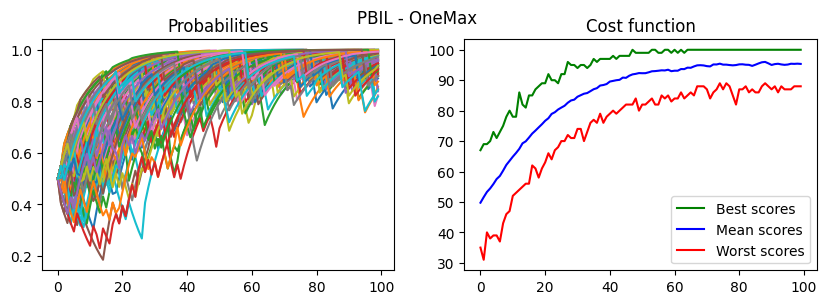

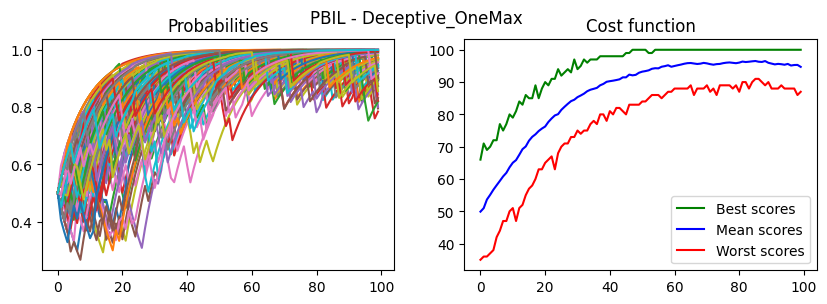

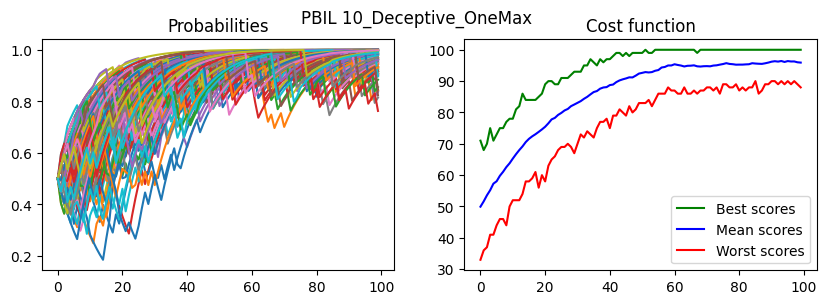

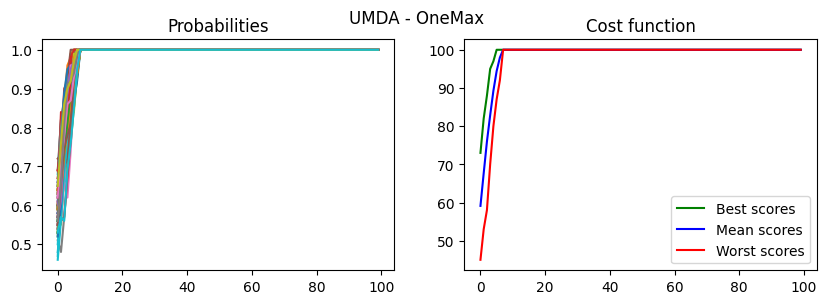

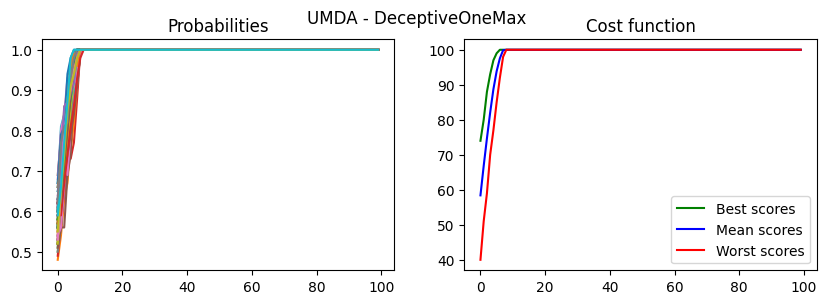

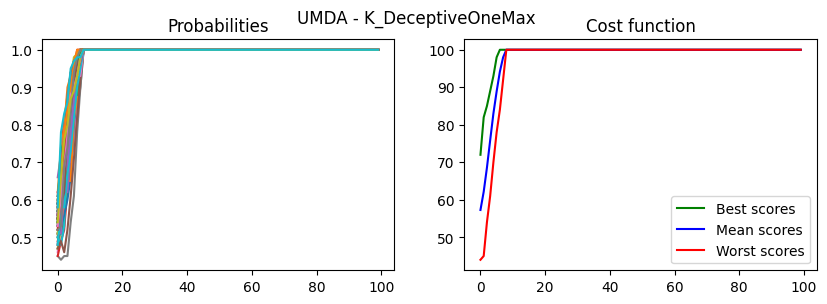

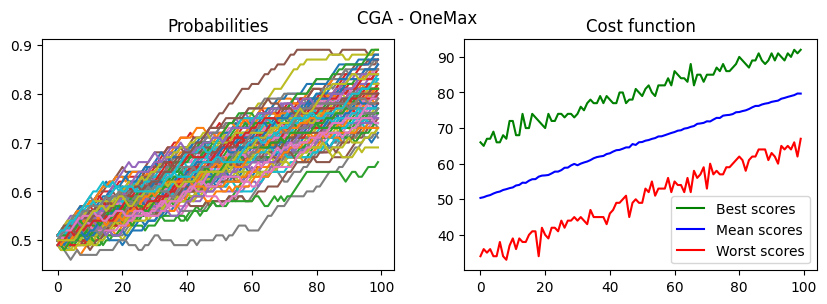

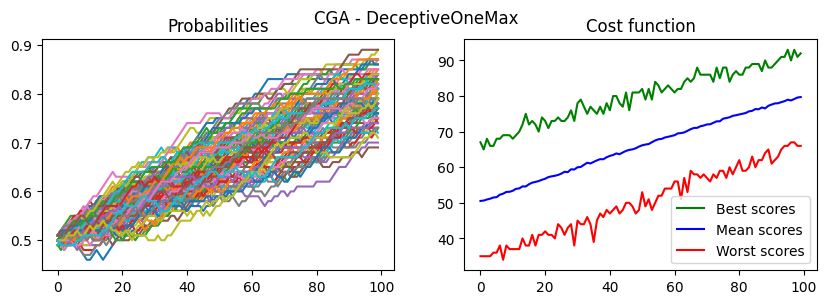

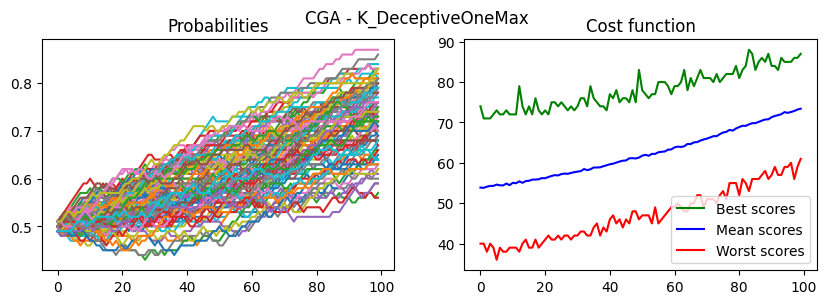

In [16]:
test_PBIL(N=1000, T=100, theta1=0.1, theta2=0.1, theta3=0.1, iters = 100)
test_UMDA(d=100, N=1000, M=100, iters=100)
test_CGA(d=100, N=1000, Theta=0.01, iters=100)